In [38]:
# PyTorch Core Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch Utilities
from torch.utils.data import DataLoader, random_split

# Torchvision Libraries
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights

In [39]:
torch.cuda.empty_cache()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [41]:
data_dir= "dataset/images/Images"
# Split dataset into train, val, and test
dataset = datasets.ImageFolder(data_dir)
train_size = int(0.85 * len(dataset))
val_size = int(0.15 * len(dataset))
train_dataset, val_dataset= random_split(dataset, [train_size, val_size])

In [42]:
# Hyperparameters
num_classes = 120  # Number of dog breeds
batch_size = 32
epochs = 10
learning_rate = 0.001
in_channels = 3  # RGB image

In [43]:
# Data transforms
transform = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [44]:

# Apply validation transform to val and test datasets
train_dataset.dataset.transform = transform["train"]
val_dataset.dataset.transform = transform["val"]


In [45]:
train_loader = torch.utils.data.DataLoader(train_dataset,          # our raw data
                                           batch_size=batch_size,  # the size of batches we want the dataloader to return
                                           shuffle=True,           # shuffle our data before batching
                                           drop_last=False)
val_loader = torch.utils.data.DataLoader(val_dataset,          # our raw data
                                           batch_size=batch_size*2,  # the size of batches we want the dataloader to return
                                           shuffle=True,           # shuffle our data before batching
                                           drop_last=False)

# Defining Model Arsitektur

In [46]:
class CustomCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomCNN, self).__init__()
        
        # Residual Block 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        self.shortcut1 = nn.Conv2d(in_channels, 64, kernel_size=1, stride=1)

        # Residual Block 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Stride=2 untuk downsampling
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )
        self.shortcut2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2),
            nn.BatchNorm2d(128)
        )

        # Residual Block 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256)
        )
        self.shortcut3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2),
            nn.BatchNorm2d(256)
        )

        # Adaptive Pooling and Fully Connected
        self.pool = nn.AdaptiveAvgPool2d((7, 7))  # Ukuran output [256, 7, 7]
        self.fc = nn.Linear(256 * 7 * 7, num_classes)  # Sesuaikan num_classes

    def forward(self, x):
        # Residual Block 1
        out = self.layer1(x)
        out += self.shortcut1(x)
        out = F.relu(out)

        # Residual Block 2
        x = out
        out = self.layer2(x)
        out += self.shortcut2(x)
        out = F.relu(out)

        # Residual Block 3
        x = out
        out = self.layer3(x)
        out += self.shortcut3(x)
        out = F.relu(out)

        # Adaptive Pooling dan Flatten
        out = self.pool(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out

model1 = CustomCNN(in_channels, num_classes).to(device)


In [47]:
# Define the model (using a pre-trained ResNet)
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleResNet, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Replace the final layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        

    def forward(self, x):
        return self.model(x)

model2 = SimpleResNet(num_classes).to(device)
model2.eval()


SimpleResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [48]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)


#   Training both Model

In [11]:
# Training and validation loop
for epoch in range(epochs):
    # Training
    model1.train()  # Set model1 to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer1.zero_grad()  # Zero the gradients
        outputs = model1(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer1.step()  # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)  # Get the index of the max output (predicted class)
        total += labels.size(0)  # Number of examples in the batch
        correct += predicted.eq(labels).sum().item()  # Count correct predictions

    # Compute training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total

    # Validation
    model1.eval()  # Set model1 to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item()
            _, predicted = outputs.max(1)  # Get the index of the max output (predicted class)
            total += labels.size(0)  # Number of examples in the batch
            correct += predicted.eq(labels).sum().item()  # Count correct predictions

    # Compute validation metrics
    val_loss /= len(val_loader)
    val_accuracy = 100.0 * correct / total

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 4.6360, Train Acc: 3.80%, Val Loss: 4.3546, Val Acc: 6.32%
Epoch 2/10, Train Loss: 4.0423, Train Acc: 10.47%, Val Loss: 4.1509, Val Acc: 9.46%
Epoch 3/10, Train Loss: 3.5929, Train Acc: 17.69%, Val Loss: 4.3098, Val Acc: 10.66%
Epoch 4/10, Train Loss: 3.1256, Train Acc: 25.94%, Val Loss: 4.2356, Val Acc: 12.21%
Epoch 5/10, Train Loss: 2.5955, Train Acc: 37.15%, Val Loss: 4.3936, Val Acc: 12.28%
Epoch 6/10, Train Loss: 2.0463, Train Acc: 48.08%, Val Loss: 4.7922, Val Acc: 13.74%
Epoch 7/10, Train Loss: 1.4841, Train Acc: 60.86%, Val Loss: 5.1394, Val Acc: 12.60%
Epoch 8/10, Train Loss: 0.9993, Train Acc: 72.42%, Val Loss: 6.1337, Val Acc: 10.85%
Epoch 9/10, Train Loss: 0.6189, Train Acc: 82.51%, Val Loss: 7.3396, Val Acc: 12.28%
Epoch 10/10, Train Loss: 0.3789, Train Acc: 89.53%, Val Loss: 7.4278, Val Acc: 12.44%


In [12]:
# Save the model
torch.save(model1.state_dict(), "models/stanford_dogs_model_CustomCNN.pth")


In [13]:
# Training and validation
for epoch in range(epochs):
    # Training
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer2.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total

    # Validation
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100.0 * correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 2.7265, Train Acc: 29.31%, Val Loss: 2.6478, Val Acc: 33.50%
Epoch 2/10, Train Loss: 1.7542, Train Acc: 49.28%, Val Loss: 2.6393, Val Acc: 34.47%
Epoch 3/10, Train Loss: 1.2843, Train Acc: 60.68%, Val Loss: 2.1091, Val Acc: 44.74%
Epoch 4/10, Train Loss: 0.9275, Train Acc: 70.53%, Val Loss: 1.9898, Val Acc: 48.88%
Epoch 5/10, Train Loss: 0.6713, Train Acc: 78.11%, Val Loss: 2.2635, Val Acc: 48.23%
Epoch 6/10, Train Loss: 0.5114, Train Acc: 83.35%, Val Loss: 2.1170, Val Acc: 50.60%
Epoch 7/10, Train Loss: 0.3871, Train Acc: 87.65%, Val Loss: 2.7585, Val Acc: 45.51%
Epoch 8/10, Train Loss: 0.3098, Train Acc: 90.08%, Val Loss: 2.1972, Val Acc: 51.96%
Epoch 9/10, Train Loss: 0.2855, Train Acc: 90.98%, Val Loss: 2.4712, Val Acc: 48.69%
Epoch 10/10, Train Loss: 0.2359, Train Acc: 92.49%, Val Loss: 2.6916, Val Acc: 46.87%


In [14]:
# Save the model
torch.save(model2.state_dict(), "models/stanford_dogs_model_ResNet18.pth")


# (Optional) - Load Model for Evaluation

In [49]:
# Load pre-trained models
model1.load_state_dict(torch.load("models/stanford_dogs_model_CustomCNN.pth"))
model2.load_state_dict(torch.load("models/stanford_dogs_model_ResNet18.pth"))

# Set models to evaluation mode
model1.eval()
model2.eval()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18960\801161078.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load("models/stanford_dogs_mode

SimpleResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

#   EVALUATION

In [50]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Evaluate both models
val_loss1, val_acc1 = evaluate_model(model1, val_loader, criterion, device)
val_loss2, val_acc2 = evaluate_model(model2, val_loader, criterion, device)

print(f"Model 1 - Val Loss: {val_loss1:.4f}, Val Accuracy: {val_acc1:.2f}%")
print(f"Model 2 - Val Loss: {val_loss2:.4f}, Val Accuracy: {val_acc2:.2f}%")



Model 1 - Val Loss: 1.1791, Val Accuracy: 82.99%
Model 2 - Val Loss: 0.6387, Val Accuracy: 84.29%


#   Comparison both model

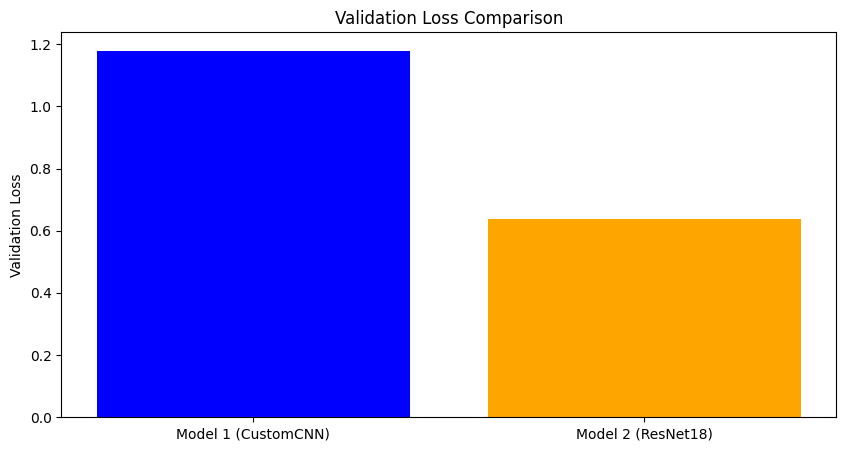

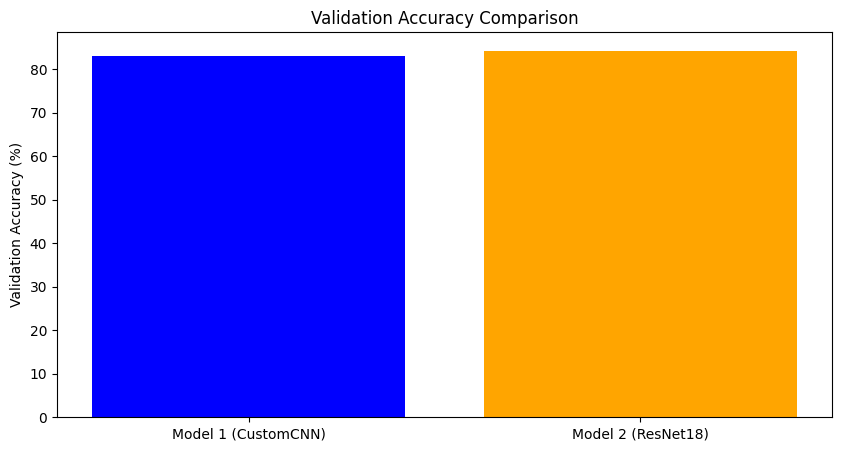

In [51]:
import matplotlib.pyplot as plt

models = ['Model 1 (CustomCNN)', 'Model 2 (ResNet18)']
val_losses = [val_loss1, val_loss2]
val_accuracies = [val_acc1, val_acc2]

# Bar plot for loss
plt.figure(figsize=(10, 5))
plt.bar(models, val_losses, color=['blue', 'orange'])
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.show()

# Bar plot for accuracy
plt.figure(figsize=(10, 5))
plt.bar(models, val_accuracies, color=['blue', 'orange'])
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.show()


In [25]:
class_names = dataset.classes  # List nama kelas
print(f"Jumlah kelas: {len(class_names)}")
print(f"Nama kelas: {class_names}")

Jumlah kelas: 120
Nama kelas: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_te

In [52]:
from sklearn.metrics import classification_report

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.92      0.83      0.87        29
              n02085782-Japanese_spaniel       0.93      0.86      0.89        29
                   n02085936-Maltese_dog       0.95      0.75      0.84        48
                      n02086079-Pekinese       0.71      1.00      0.83        34
                      n02086240-Shih-Tzu       0.78      0.83      0.81        30
              n02086646-Blenheim_spaniel       0.96      0.93      0.95        29
                      n02086910-papillon       0.89      0.96      0.92        25
                   n02087046-toy_terrier       0.83      0.94      0.88        32
           n02087394-Rhodesian_ridgeback       0.62      1.00      0.76        26
                  n02088094-Afghan_hound       0.95      0.90      0.92        39
                        n02088238-basset       0.72      0.90      0.80        20
               

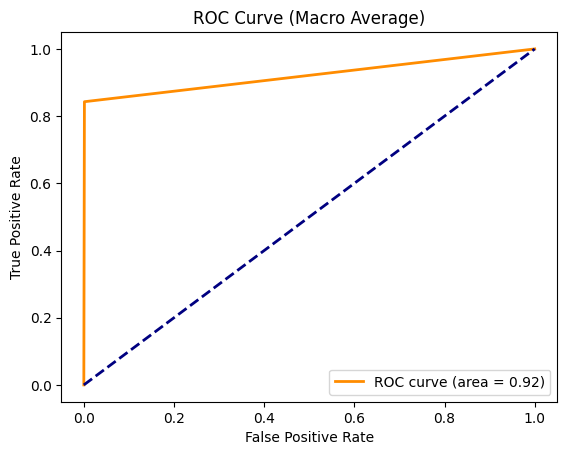

In [53]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarisasi label
y_true_binary = label_binarize(y_true, classes=range(len(class_names)))
y_pred_binary = label_binarize(y_pred, classes=range(len(class_names)))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_binary.ravel(), y_pred_binary.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Macro Average)')
plt.legend(loc="lower right")
plt.show()


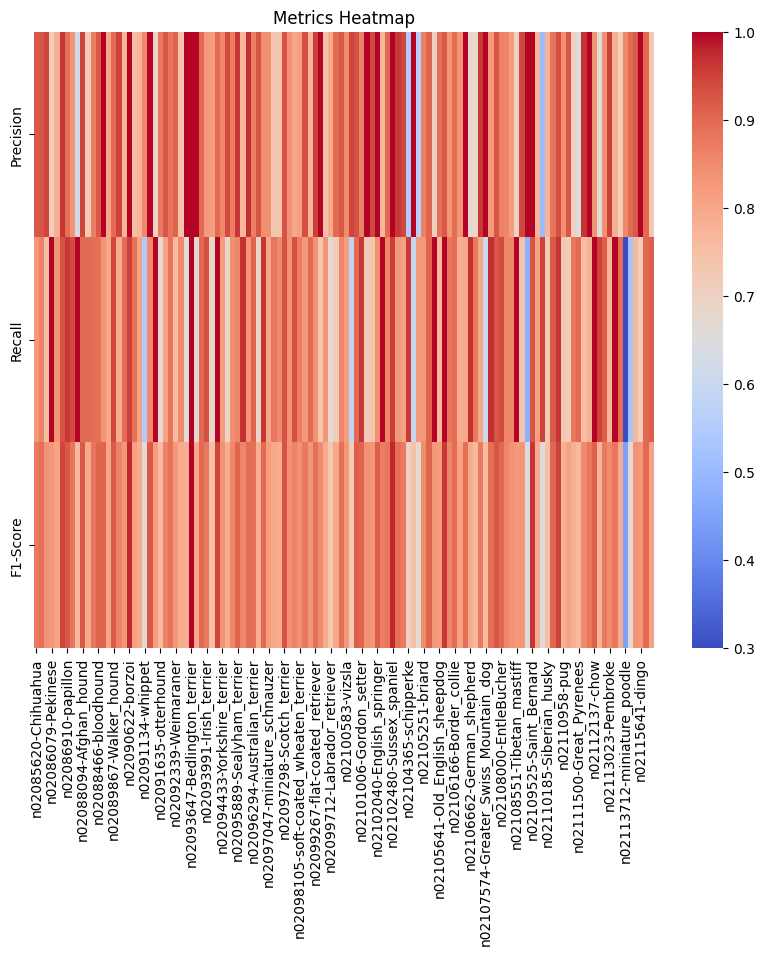

In [54]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(metrics, index=class_names).T, cmap='coolwarm', annot=False)
plt.title("Metrics Heatmap")
plt.show()


# Testing

Predicted Class: n02085620-Chihuahua


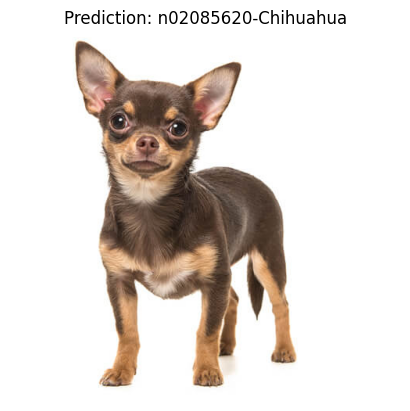

In [34]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan memproses gambar
def process_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")  
    image = transform(image) 
    return image

# Fungsi untuk memprediksi kelas gambar
def predict_image(image_path, model, class_names, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),         
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    
    # Proses gambar
    image = process_image(image_path, transform).unsqueeze(0).to(device) 
    
    # Prediksi dengan model
    model.eval()  
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)  
    
    # Tampilkan hasil
    predicted_class = class_names[predicted.item()]
    print(f"Predicted Class: {predicted_class}")
    
    # Tampilkan gambar
    plt.imshow(Image.open(image_path))
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()


model = model2
image_path = "BREED Hero_0034_chihuahua_smooth.jpg"
class_names = dataset.classes

# Prediksi gambar
predict_image(image_path, model, class_names, device='cuda' if torch.cuda.is_available() else 'cpu')


# (optional) kebutuhan serving model

In [55]:
import json

class_names = dataset.classes  # Daftar nama kelas dari dataset
with open("models/class_labels.json", "w") as f:
    json.dump({str(i): name for i, name in enumerate(class_names)}, f)
